***Week1-6***



***We import useful librairies***

In [1]:
pip install datacleaner

  Created wheel for datacleaner: filename=datacleaner-0.1.5-cp36-none-any.whl size=7412 sha256=f2f528fc1decc61592abb603b248792887d73b4c038594dc2d782a76523bb29d
  Stored in directory: /root/.cache/pip/wheels/47/e3/74/4e055e42b3d4a5deab827f4d950e8e71d506c6e79231ad4576
Successfully built datacleaner


In [0]:
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sn
import matplotlib.pyplot as plt
from datacleaner import autoclean
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time
import os

In [123]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
os.chdir("/content/drive/My Drive")

***Data loading***

In [0]:
transaction_train = pd.read_csv('train_transaction.csv')
identity_train = pd.read_csv('train_identity.csv')
transaction_test = pd.read_csv('test_transaction.csv')
identity_test = pd.read_csv('test_identity.csv')

In [219]:
transaction_train.shape

(590540, 394)

***A) Data preprocessing***

***Merging dataset***

In [0]:
X_train = transaction_train.join(identity_train.set_index('TransactionID'), on= 'TransactionID')

In [232]:
X_train.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [0]:
X_test =  transaction_test.join(identity_test.set_index('TransactionID'), on= 'TransactionID')

In [234]:
X_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
X_train.shape, X_test.shape

((590540, 434), (506691, 433))

***Target: isFraud***

In [236]:
y_train = X_train.isFraud
X_train = X_train.drop(['isFraud', 'TransactionID'],axis= 1)
transactionIDTest = X_test['TransactionID']
X_test = X_test.drop('TransactionID', axis= 1)
X_train.shape, X_test.shape

((590540, 432), (506691, 432))

***Data cleaning***

In [238]:
X_train.isnull().sum()

TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
                   ...  
id_36             449555
id_37             449555
id_38             449555
DeviceType        449730
DeviceInfo        471874
Length: 432, dtype: int64

***First time : We decide to drop features with 70% of Nan values.***


In [0]:
droppedColumns = []
for i in X_train.columns:
  nanSum = X_train[i].isnull().sum()
  proportion = nanSum/X_train.shape[0]
  if proportion > 0.70:
    X_train = X_train.drop(i, axis= 1)  
    droppedColumns.append(i)    

In [240]:
X_train.shape 

(590540, 224)

***Features dropped in X_train***

In [241]:
droppedColumns

['dist2',
 'R_emaildomain',
 'D6',
 'D7',
 'D8',
 'D9',
 'D12',
 'D13',
 'D14',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 '

***We don't know what each column describes exactly. After looking on kaggle website discussion, we found the following information.***

***TransactionDT: timedelta from a given reference datetime (not an actual timestamp)*** 

***TransactionAMT : That is transaction amount in USD**

***ProductCD: Product code for each transaction***

***card1 - card6: Information about payment card*** 

***addr: Address for purchaser and recipient***

***addr1 as billing region***

***addr2 as billing country***

***dist: distance ***
***"distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc***


***P_ and (R_) emaildomain: Purchaser and recipient email domain ***

***C1-C14: Counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. ***

***D1-D15: Timedelta, such as days between previous transaction, etc. ***

***M1-M9: Match, such as names on card and address, etc.***

***Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.***

***id01-id11 : Numerical features for identity***

***IsFraud =1 means fradulent transaction, otherwise nofradulent transaction.***


***Distribution of target (fradulent and nonfradulent transaction)***

In [242]:
y_train.value_counts(normalize= True)

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

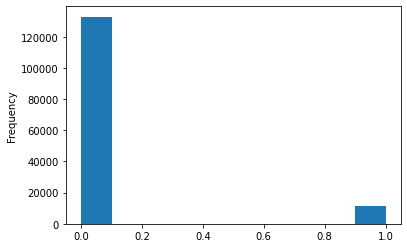

In [137]:
y_train.plot.hist()

***We have approximatively 96% of non fradulent transaction and 4% of fradulent transaction.***

***Let's replace missing values in each features. We will use datacleaner library for dealing with numerical features. The method autoclean from datacleaner library replaces Nan in numerical features by its median.***

***Its documentation can be find there 
https://github.com/rhiever/datacleaner***

***We create a mask for selecting categorical features.***

In [243]:
mask1 = X_train.dtypes==object
categoricalColumns = X_train.columns[mask1]
categoricalFeatures = X_train[categoricalColumns]
categoricalFeatures.head()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***Mask for selecting numerical features***

In [244]:
mask2 = X_train.dtypes!=object
numericalColumns = X_train.columns[mask2]
numericalFeatures = X_train[numericalColumns]
numericalFeatures.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,13.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,315.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,NaN,111.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***Removing Nan in numerical features in training dataset***

In [245]:
numericalFeatures = autoclean(numericalFeatures)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [246]:
numericalFeatures.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,86400,68.5,13926,361.0,150.0,142.0,315.0,87.0,19.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,13.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,43.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,315.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,8.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,43.0,111.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,26.0,10.0,15.0,43.0,52.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [247]:
numericalFeatures.isnull().sum()

TransactionDT     0
TransactionAmt    0
card1             0
card2             0
card3             0
                 ..
V317              0
V318              0
V319              0
V320              0
V321              0
Length: 211, dtype: int64

***Verification of zero-Nan in each feature***

In [248]:
nonNull = numericalFeatures.isnull().sum() != 0
columnNonNull = numericalFeatures.columns[nonNull]
columnNonNull

Index([], dtype='object')

***Correlation between some numerical features .***

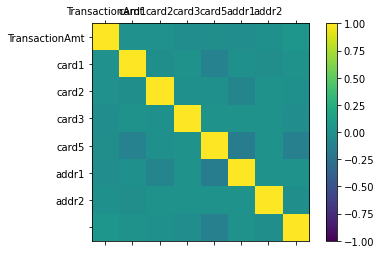

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2
TransactionDT,1.000000,0.011920,0.010625,-0.019056,-0.011740,-0.023348,0.000057,0.049312
TransactionAmt,0.011920,1.000000,-0.005725,0.015942,-0.109646,0.003791,-0.011019,0.024621
card1,0.010625,-0.005725,1.000000,0.004960,0.002966,-0.093550,0.019194,0.000015
card2,-0.019056,0.015942,0.004960,1.000000,0.023816,0.030507,0.029819,-0.019599
card3,-0.011740,-0.109646,0.002966,0.023816,1.000000,-0.159321,0.020647,-0.131724
card5,-0.023348,0.003791,-0.093550,0.030507,-0.159321,1.000000,0.027334,0.028312
addr1,0.000057,-0.011019,0.019194,0.029819,0.020647,0.027334,1.000000,-0.002094
addr2,0.049312,0.024621,0.000015,-0.019599,-0.131724,0.028312,-0.002094,1.000000


In [254]:
correlations1 = numericalFeatures[['TransactionDT','TransactionAmt',	'card1',	'card2','card3','card5','addr1','addr2']].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations1, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['TransactionDT','TransactionAmt',	'card1',	'card2','card3','card5','addr1','addr2']
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations1

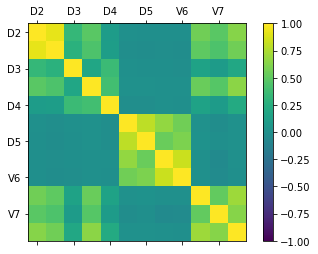

,D1,D2,D3,D4,D5,V6,V7,V8,V9,D10,D11,D15
D1,1.000000,0.925464,0.335385,0.491005,0.107348,0.000430,-0.001273,-0.002895,-0.001776,0.567605,0.485585,0.636458
D2,0.925464,1.000000,0.273609,0.439608,0.117044,-0.009282,-0.019907,-0.013692,-0.021864,0.507729,0.441188,0.567743
D3,0.335385,0.273609,1.000000,0.182282,0.362950,0.001030,-0.003661,-0.002801,-0.008727,0.153564,0.098064,0.195438
D4,0.491005,0.439608,0.182282,1.000000,0.394047,0.009018,0.010803,0.005444,0.005814,0.545247,0.471747,0.653335
D5,0.107348,0.117044,0.362950,0.394047,1.000000,-0.008887,-0.015507,0.000660,-0.005628,0.155899,0.096320,0.221107
V6,0.000430,-0.009282,0.001030,0.009018,-0.008887,1.000000,0.799914,0.679529,0.568471,0.011938,-0.016465,0.009374
V7,-0.001273,-0.019907,-0.003661,0.010803,-0.015507,0.799914,1.000000,0.545213,0.602797,0.016639,-0.004185,0.011692
V8,-0.002895,-0.013692,-0.002801,0.005444,0.000660,0.679529,0.545213,1.000000,0.837211,0.003932,-0.039439,0.000780
V9,-0.001776,-0.021864,-0.008727,0.005814,-0.005628,0.568471,0.602797,0.837211,1.000000,0.005392,-0.033350,-0.001483
D10,0.567605,0.507729,0.153564,0.545247,0.155899,0.011938,0.016639,0.003932,0.005392,1.000000,0.522699,0.708108


In [255]:
correlations2 = numericalFeatures[['D1',	'D2',	'D3',	'D4',	'D5', 'V6','V7',	'V8',	'V9','D10',	'D11','D15']].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations2, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['D1',	'D2',	'D3',	'D4',	'D5', 'V6','V7',	'V8',	'V9','D10',	'D11','D15']
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations2

***Conclusion: We can not deduce a correlation between these features.***

***Standardization of numerical features***

In [0]:
numericalFeatures = (numericalFeatures-numericalFeatures.mean())/numericalFeatures.std()


In [257]:
numericalFeatures.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,-1.577985,-0.278167,0.821695,-0.009783,-0.281424,-1.396379,0.243321,0.069833,-0.138579,-0.098020,-0.092260,-0.037493,-0.059438,-0.21606,-0.112869,-0.046146,-0.053938,-0.208711,-0.054826,-0.087363,-0.047034,-0.243806,-0.147246,-0.508743,-0.285238,-0.132212,-0.480224,-0.242242,-0.556176,-0.585028,-0.768856,0.005365,-0.135535,-0.174217,0.246322,0.184755,-0.137377,-0.171279,-0.107532,-0.132158,...,0.198101,0.005694,-0.26163,-0.355724,-0.164931,-0.332323,-0.427193,-0.393307,-0.133971,-0.040597,-0.063552,-0.045782,-0.033239,-0.055210,-0.100639,-0.141693,-0.094117,-0.099554,-0.156979,-0.163187,-0.522440,-0.454029,-0.500162,-0.002603,-0.059496,-0.066411,-0.076246,-0.094585,-0.334844,-0.041046,-0.227583,-0.222385,-0.249222,-0.229148,-0.048377,-0.032814,-0.058049,-0.055287,-0.088855,-0.074142
1,-1.577985,-0.443327,-1.457557,0.264810,-0.281424,-2.368252,0.347542,0.069833,-0.183967,-0.098020,-0.092260,-0.037493,-0.059438,-0.21606,-0.112869,-0.046146,-0.053938,-0.268682,-0.054826,-0.097964,-0.047034,-0.243806,-0.147246,-0.597605,-0.285238,-0.237350,-0.633627,-0.242242,-0.630751,-0.377609,-0.768856,0.005365,-0.135535,-0.174217,0.246322,0.184755,-0.137377,-0.171279,-0.107532,-0.132158,...,0.198101,0.005694,-0.26163,-0.355724,-0.164931,-0.332323,-0.427193,-0.393307,-0.133971,-0.040597,-0.063552,-0.045782,-0.058539,-0.055210,-0.100639,-0.141693,-0.094117,-0.099554,-0.156979,-0.163187,-0.522440,-0.454029,-0.500162,-0.002603,-0.059496,-0.093051,-0.076246,-0.094585,-0.334844,-0.041046,-0.227583,-0.222385,-0.249222,-0.229148,-0.048377,-0.062211,-0.058049,-0.055287,-0.088855,-0.074142
2,-1.577970,-0.317889,-1.068262,0.813996,-0.281424,-0.813254,0.399653,0.069833,0.967245,-0.098020,-0.092260,-0.037493,-0.059438,-0.21606,-0.112869,-0.046146,-0.053938,-0.208711,-0.054826,-0.097964,-0.047034,-0.243806,-0.147246,-0.597605,-0.285238,-0.237350,-0.633627,-0.242242,-0.630751,1.502993,0.880013,0.005365,-0.135535,-0.174217,0.246322,0.184755,-0.137377,-0.171279,-0.107532,-0.132158,...,0.198101,0.005694,-0.26163,-0.355724,-0.164931,-0.332323,-0.427193,-0.393307,-0.133971,-0.040597,-0.063552,-0.045782,-0.058539,-0.055210,-0.100639,-0.141693,-0.094117,-0.099554,-0.156979,-0.163187,-0.522440,-0.454029,-0.500162,-0.002603,-0.059496,-0.093051,-0.076246,-0.094585,-0.334844,-0.041046,-0.227583,-0.222385,-0.249222,-0.229148,-0.048377,-0.062211,-0.058049,-0.055287,-0.088855,-0.074142
3,-1.577964,-0.355520,1.679857,1.305709,-0.281424,-2.003800,1.921290,0.069833,-0.183967,-0.090533,-0.066398,-0.037493,-0.059438,-0.21606,-0.070916,-0.046146,-0.053938,-0.208711,-0.054826,-0.097964,-0.047034,-0.058284,-0.147246,0.113291,-0.172822,-0.405571,-0.079017,-0.399848,-0.148879,-0.377609,-0.187826,0.005365,-0.135535,-0.174217,0.246322,0.184755,-0.137377,-0.171279,-0.107532,-0.132158,...,-0.887761,-0.636544,-0.26163,2.690805,-0.164931,3.374863,-0.427193,-0.393307,-0.133971,-0.040597,-0.063552,0.002789,0.902852,0.869194,-0.100639,-0.141693,-0.094117,-0.099554,-0.156979,-0.163187,-0.522440,-0.454029,-0.500162,-0.002603,-0.038209,0.307227,0.229853,-0.094585,0.668046,-0.041046,0.556723,-0.222385,-0.249222,-0.229148,-0.026351,0.290552,0.224769,-0.055287,-0.088855,-0.074142
4,-1.577962,-0.355520,-1.102132,0.967258,-0.281424,-2.368252,1.337648,0.069833,-0.183967,-0.098020,-0.092260,-0.037493,-0.059438,-0.21606,-0.112869,-0.046146,-0.043454,-0.268682,-0.044364,-0.097964,-0.047034,-0.243806,-0.147246,-0.597605,-0.285238,-0.237350,-0.480224,-0.242242,-0.544703,-0.377609,-0.496662,0.005365,-0.135535,-0.174217,0.246322,0.184755,-0.137377,-0.171279,-0.107532,-0.132158,...,0.198101,0.005694,-0.26163,-0.355724,-0.164931,-0.3323

***If one feature has the same value, the new value after standardization will be equal to NaN. So, we will drop features which have NaN after normalization.***

In [258]:
nonNull = numericalFeatures.isnull().sum() != 0
columnNonNullScaled = numericalFeatures.columns[nonNull]
columnNonNullScaled

Index([], dtype='object')

***Test dataset cleaning*** 

***First time, we rename column name of test dataset: We replace - by _***

In [0]:
droppedColumnsTest = []
for i in X_test.columns:
  a = i.replace('-','_')
  droppedColumnsTest.append(a)
X_test.columns = droppedColumnsTest

***Extracting categorical and numerical features***

In [0]:
X_testCategorical = X_test[categoricalFeatures.columns]

In [0]:
X_testNumerical  = X_test[numericalFeatures.columns]

***Removing Nan of numerical features.***

In [262]:
X_testNumerical = autoclean(X_testNumerical)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


***We verify if the categorical features of training and test set have the same number of unique value before encoding*** 


In [263]:
categoricalFeatures.describe()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,590540,588963,588969,496084,319440,319440,319440,309096,240058,421180,244275,244288,244288
unique,5,4,4,59,2,2,2,3,2,2,2,2,2
top,W,visa,debit,gmail.com,T,T,T,M0,F,F,F,F,T
freq,439670,384767,439938,228355,319415,285468,251731,196405,132491,227856,211374,155251,205656


In [264]:
X_testCategorical.describe()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,506691,503605,503684,437499,330052,330052,330052,268946,197059,347752,271673,271687,271687
unique,5,4,3,60,2,2,2,3,2,2,2,2,2
top,W,visa,debit,gmail.com,T,T,T,M0,F,F,F,F,T
freq,360987,334882,385021,207448,330021,302855,266513,161384,107664,191577,233230,168399,236279


***We remark that some categorical features have different unique value in training and test set. That will lead to different shape of training and test sets. We decide to remove these features.***

***Categorical features with different value***

In [265]:
A = []
for i in X_testCategorical.columns:
  if len(X_testCategorical[i].value_counts()) != len(categoricalFeatures[i].value_counts()):
    A.append(i)
A

['card6', 'P_emaildomain']

***Dropping these categorical features before encoding.***


In [0]:
categoricalFeatures = categoricalFeatures.drop(A, axis = 1)
X_testCategorical = X_testCategorical.drop(A, axis = 1)

***We use get_dummies method to encode categorical features of training and test set.***

In [0]:
def encodingTrain():
  x = pd.get_dummies(categoricalFeatures, columns= categoricalFeatures.columns)
  return x.join(numericalFeatures) 

In [0]:
X_trainEncoded = encodingTrain()

In [0]:
def encodingTest():
  x = pd.get_dummies(X_testCategorical, columns= X_testCategorical.columns) 
  return x.join(X_testNumerical)

In [0]:
X_testEncoded = encodingTest()

***We verify the shape of training and test sets after encoding.***

In [271]:
X_trainEncoded.shape, X_testEncoded.shape, y_train.shape

((590540, 239), (506691, 239), (590540,))

***Shape is OK.***

In [272]:
X_trainEncoded.head()

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,M1_F,M1_T,M2_F,M2_T,M3_F,M3_T,M4_M0,M4_M1,M4_M2,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,-1.577985,-0.278167,0.821695,-0.009783,-0.281424,-1.396379,0.243321,0.069833,-0.138579,-0.098020,-0.092260,-0.037493,...,0.198101,0.005694,-0.26163,-0.355724,-0.164931,-0.332323,-0.427193,-0.393307,-0.133971,-0.040597,-0.063552,-0.045782,-0.033239,-0.055210,-0.100639,-0.141693,-0.094117,-0.099554,-0.156979,-0.163187,-0.522440,-0.454029,-0.500162,-0.002603,-0.059496,-0.066411,-0.076246,-0.094585,-0.334844,-0.041046,-0.227583,-0.222385,-0.249222,-0.229148,-0.048377,-0.032814,-0.058049,-0.055287,-0.088855,-0.074142
1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,-1.577985,-0.443327,-1.457557,0.264810,-0.281424,-2.368252,0.347542,0.069833,-0.183967,-0.098020,-0.092260,-0.037493,...,0.198101,0.005694,-0.26163,-0.355724,-0.164931,-0.332323,-0.427193,-0.393307,-0.133971,-0.040597,-0.063552,-0.045782,-0.058539,-0.055210,-0.100639,-0.141693,-0.094117,-0.099554,-0.156979,-0.163187,-0.522440,-0.454029,-0.500162,-0.002603,-0.059496,-0.093051,-0.076246,-0.094585,-0.334844,-0.041046,-0.227583,-0.222385,-0.249222,-0.229148,-0.048377,-0.062211,-0.058049,-0.055287,-0.088855,-0.074142
2,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,-1.577970,-0.317889,-1.068262,0.813996,-0.281424,-0.813254,0.399653,0.069833,0.967245,-0.098020,-0.092260,-0.037493,...,0.198101,0.005694,-0.26163,-0.355724,-0.164931,-0.332323,-0.427193,-0.393307,-0.133971,-0.040597,-0.063552,-0.045782,-0.058539,-0.055210,-0.100639,-0.141693,-0.094117,-0.099554,-0.156979,-0.163187,-0.522440,-0.454029,-0.500162,-0.002603,-0.059496,-0.093051,-0.076246,-0.094585,-0.334844,-0.041046,-0.227583,-0.222385,-0.249222,-0.229148,-0.048377,-0.062211,-0.058049,-0.055287,-0.088855,-0.074142
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,-1.577964,-0.355520,1.679857,1.305709,-0.281424,-2.003800,1.921290,0.069833,-0.183967,-0.090533,-0.066398,-0.037493,...,-0.887761,-0.636544,-0.26163,2.690805,-0.164931,3.374863,-0.427193,-0.393307,-0.133971,-0.040597,-0.063552,0.002789,0.902852,0.869194,-0.100639,-0.141693,-0.094117,-0.099554,-0.156979,-0.163187,-0.522440,-0.454029,-0.500162,-0.002603,-0.038209,0.307227,0.229853,-0.094585,0.668046,-0.041046,0.556723,-0.222385,-0.249222,-0.229148,-0.026351,0.290552,0.224769,-0.055287,-0.088855,-0.074142
4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1.577962,-0.355520,-1.102132,0.967258,-0.281424,-2.368252,1.337648,0.069833,-0.183967,-0.098020,-0.092260,-0.037493,...,0.198101,0.005694,-0.26163,-0.355724,-0.164931,-0.332323,-0.427193,-0.393307,-0.133971,-0.040597,-0.063552,-0.045782,-0.058539,-0.055210,-0.100639,-0.141693,-0.094117,-0.099554,-0.156979,-0.163187,1.552744,1.149554,1.392940,-0.002603,-0.059496,-0.093051,-0.076246,-0.094585,-0.334844,-0.041046,-0.227583,-0.222385,-0.249222,-0.229148,-0.048377,-0.062211,-0.058049,-0.055287,-0.088855,-0.074142


In [273]:
X_testEncoded.head()

,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card4_american express,card4_discover,card4_mastercard,card4_visa,M1_F,M1_T,M2_F,M2_T,M3_F,M3_T,M4_M0,M4_M1,M4_M2,M5_F,M5_T,M6_F,M6_T,M7_F,M7_T,M8_F,M8_T,M9_F,M9_T,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,18403224,31.95,10409,111.0,150.0,226.0,170.0,87.0,1.0,6.0,6.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,1,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,18403263,49.00,4272,111.0,150.0,226.0,299.0,87.0,4.0,3.0,2.0,0.0,...,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,18403310,171.00,4476,574.0,150.0,226.0,472.0,87.0,2635.0,2.0,2.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0
3,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,18403310,284.95,10989,360.0,150.0,166.0,205.0,87.0,17.0,5.0,2.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,18403317,67.95,18018,452.0,150.0,117.0,264.0,87.0,6.0,6.0,6.0,0.0,...,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0


***We verify if there is not Nan in training and test set after encoding.***

In [274]:
nonNull = X_trainEncoded.isnull().sum() != 0
columnNonNull = X_trainEncoded.columns[nonNull]
columnNonNull

Index([], dtype='object')

In [277]:
nonNull = X_testEncoded.isnull().sum() != 0
columnNonNull = X_testEncoded.columns[nonNull]
columnNonNull

Index([], dtype='object')

***There is not Nan.***

***We verify if columns name in training and test sets are the same.***

In [276]:
A = X_trainEncoded.columns == X_testEncoded.columns
A.sum() == len(X_trainEncoded.columns)

True

***The columns name in training and test set are the same Now, we will build the model which may avoid overfitting since we have a lof features.***

***Week6-Today***

***B) Modelling: Training and probability prediction***

***First time, we tried KNN, but it appears that it is uncomfortable. Time exécution is great and it can lead to overfitting. One decides to use ensamble model, precisely adaptative boosting algorithm.***
 

***Adaptive Boosting model***

***Optimization of hyperparameters***

In [0]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 1]}
gridCv = GridSearchCV(AdaBoostClassifier(), param_grid= parameters, cv=3, scoring='roc_auc')

In [0]:
begin = time.time()
gridCv.fit(X_trainEncoded, y_train)
end = time.time()

***a) Time of execution for optimizing hyperparameters***

In [280]:
print("Time execution for optimizing hyperparapeter is {a} minutes.".format(a =(end-begin)/60))

Time execution for optimizing hyperparapeter is 22.613291402657826 minutes.


***b)Best parameters, best estimator and best auc_ roc score***

In [281]:
gridCv.best_params_

{'learning_rate': 1}

In [282]:
gridCv.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=50, random_state=None)

In [283]:
gridCv.best_score_

0.8529081315964823

***1) Adaboost Model with all features (and best parameters)***

In [0]:
Model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=50, random_state=None)

In [0]:
begin = time.time()
Model.fit(X_trainEncoded,y_train)
end = time.time()

In [287]:
print("Time execution for optimizing hyperparapeter is {a} minutes.".format(a =(end-begin)/60))

Time execution for optimizing hyperparapeter is 2.905275372664134 minutes.


***Probability predicted by the model***

In [0]:
predictedProba11 = pd.DataFrame(Model.predict_proba(X_testEncoded), columns=['ProbaNonFraud','ProbaFraud'])

In [333]:
predictedProbaFraud11 = pd.DataFrame(predictedProba11['ProbaFraud'])
predictedProbaFraud11.insert(0,'TransactionID', transactionIDTest)
predictedProbaFraud11.index = np.arange(start=1, stop=506692, step=1)
predictedProbaFraud11.head()

,TransactionID,ProbaFraud
1,3663549,0.500120
2,3663550,0.327280
3,3663551,0.320583
4,3663552,0.488487
5,3663553,0.317899


***Let's write function for save predicted probability in cvs file***

In [0]:
def saveCSVfile(predictedProba, filename="submission.csv"):
    predictedProba.to_csv(filename, index= True)

In [0]:
saveCSVfile(predictedProbaFraud11, "predictedProbaFraud.csv")

***2) Adaboost Model with only important features (and best parameters)***

***The method feature_importances_ is used to get out important features.***

In [344]:
importantFeature = []
importantFeatureName = []
for feat, importance in zip(X_trainEncoded.columns, gridCv.best_estimator_.feature_importances_):
  if importance!= 0:
      importantFeature.append(importance)
      importantFeatureName.append(feat)
      print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

feature: ProductCD_R, importance: 0.02
feature: card4_discover, importance: 0.02
feature: M3_T, importance: 0.02
feature: M5_F, importance: 0.02
feature: M6_T, importance: 0.02
feature: TransactionDT, importance: 0.02
feature: TransactionAmt, importance: 0.04
feature: card1, importance: 0.04
feature: card3, importance: 0.04
feature: card5, importance: 0.04
feature: dist1, importance: 0.02
feature: C1, importance: 0.08
feature: C3, importance: 0.02
feature: C6, importance: 0.04
feature: C8, importance: 0.04
feature: C11, importance: 0.02
feature: C12, importance: 0.02
feature: C13, importance: 0.04
feature: C14, importance: 0.08
feature: D2, importance: 0.02
feature: D3, importance: 0.02
feature: D5, importance: 0.02
feature: D15, importance: 0.02
feature: V45, importance: 0.06
feature: V55, importance: 0.02
feature: V69, importance: 0.02
feature: V70, importance: 0.02
feature: V75, importance: 0.02
feature: V87, importance: 0.02
feature: V96, importance: 0.02
feature: V294, importance:

***Training and test set with only important features***

In [0]:
X_trainEncodedBest = X_trainEncoded[importantFeatureName]
X_testEncodedBest = X_testEncoded[importantFeatureName]

In [346]:
X_trainEncodedBest.head() 

,ProductCD_R,card4_discover,M3_T,M5_F,M6_T,TransactionDT,TransactionAmt,card1,card3,card5,dist1,C1,C3,C6,C8,C11,C12,C13,C14,D2,D3,D5,D15,V45,V55,V69,V70,V75,V87,V96,V294,V304,V315,V316,V317
0,0,1,1,1,1,-1.577985,-0.278167,0.821695,-0.281424,-1.396379,-0.138579,-0.098020,-0.037493,-0.112869,-0.053938,-0.087363,-0.047034,-0.243806,-0.147246,-0.285238,-0.132212,-0.242242,-0.768856,-0.13929,-0.160914,-0.68302,-0.662942,0.771968,-0.178728,-0.049805,-0.033239,-0.500162,-0.229148,-0.048377,-0.032814
1,0,0,0,0,1,-1.577985,-0.443327,-1.457557,-0.281424,-2.368252,-0.183967,-0.098020,-0.037493,-0.112869,-0.053938,-0.097964,-0.047034,-0.243806,-0.147246,-0.285238,-0.237350,-0.242242,-0.768856,-0.13929,-0.160914,-0.68302,-0.662942,-1.223226,-0.178728,-0.074663,-0.058539,-0.500162,-0.229148,-0.048377,-0.062211
2,0,0,1,1,0,-1.577970,-0.317889,-1.068262,-0.281424,-0.813254,0.967245,-0.098020,-0.037493,-0.112869,-0.053938,-0.097964,-0.047034,-0.243806,-0.147246,-0.285238,-0.237350,-0.242242,0.880013,-0.13929,-0.160914,-0.68302,-0.662942,0.771968,-0.178728,-0.074663,-0.058539,-0.500162,-0.229148,-0.048377,-0.062211
3,0,0,0,0,0,-1.577964,-0.355520,1.679857,-0.281424,-2.003800,-0.183967,-0.090533,-0.037493,-0.070916,-0.053938,-0.097964,-0.047034,-0.058284,-0.147246,-0.172822,-0.405571,-0.399848,-0.187826,-0.13929,-0.160914,-0.68302,-0.662942,0.771968,-0.178728,1.118511,0.902852,-0.500162,-0.229148,-0.026351,0.290552
4,0,0,0,0,0,-1.577962,-0.355520,-1.102132,-0.281424,-2.368252,-0.183967,-0.098020,-0.037493,-0.112869,-0.043454,-0.097964,-0.047034,-0.243806,-0.147246,-0.285238,-0.237350,-0.242242,-0.496662,-0.13929,-0.160914,-0.68302,-0.662942,0.771968,-0.178728,-0.074663,-0.058539,1.392940,-0.229148,-0.048377,-0.062211


In [353]:
X_testEncodedBest.head()

,ProductCD_R,card4_discover,M3_T,M5_F,M6_T,TransactionDT,TransactionAmt,card1,card3,card5,dist1,C1,C3,C6,C8,C11,C12,C13,C14,D2,D3,D5,D15,V45,V55,V69,V70,V75,V87,V96,V294,V304,V315,V316,V317
0,0,0,0,0,0,18403224,31.95,10409,150.0,226.0,1.0,6.0,0.0,4.0,0.0,5.0,1.0,115.0,6.0,419.0,27.0,27.0,409.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.0,0.0
1,0,0,0,0,0,18403263,49.00,4272,150.0,226.0,4.0,3.0,0.0,1.0,0.0,1.0,1.0,12.0,2.0,149.0,7.0,7.0,634.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,0.0,0.0,0.000000,0.0,0.0
2,0,0,0,1,0,18403310,171.00,4476,150.0,226.0,2635.0,2.0,0.0,5.0,0.0,2.0,0.0,22.0,2.0,137.0,10.0,10.0,97.0,1.0,1.0,0.0,0.0,1.0,1.0,5.0,0.0,0.0,0.000000,0.0,0.0
3,0,0,1,0,1,18403310,284.95,10989,150.0,166.0,17.0,5.0,0.0,1.0,0.0,2.0,0.0,7.0,4.0,42.0,41.0,41.0,242.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,282.540009,0.0,0.0
4,0,0,1,0,0,18403317,67.95,18018,150.0,117.0,6.0,6.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,0.0,0.0,22.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,0.0,0.0,67.949997,0.0,0.0


In [0]:
begin = time.time()
crossValScore = cross_val_score(Model, X_trainEncodedBest, y_train, cv= 3, scoring='roc_auc')
end = time.time()

In [351]:
print("auc score is: {f}".format(f=np.mean(crossValScore)))
print("Time exécution is {a} minutes".format(a = (end-begin)/60))

auc score is: 0.851786650944034
Time exécution is 1.417334763209025 minutes


***Probability of fradulent transaction predicted by our best model***

In [359]:
X_testEncodedBest.shape, X_trainEncodedBest.shape, y_train.shape

((506691, 35), (590540, 35), (590540,))

In [363]:
Model.fit(X_trainEncodedBest,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=50, random_state=None)

In [0]:
predictedProba22 = pd.DataFrame(Model.predict_proba(X_testEncodedBest), columns=['ProbaNonFraud','ProbaFraud'])

In [365]:
predictedProbaFraud22 = pd.DataFrame(predictedProba11['ProbaFraud'])
predictedProbaFraud22.insert(0,'TransactionID', transactionIDTest)
predictedProbaFraud22.index = np.arange(start=1, stop=506692, step=1)
predictedProbaFraud22.head()

,TransactionID,ProbaFraud
1,3663549,0.500120
2,3663550,0.327280
3,3663551,0.320583
4,3663552,0.488487
5,3663553,0.317899


In [0]:
saveCSVfile(predictedProbaFraud22, "predictedProbaFraud22.csv")

***Conclusion: Our model using all features takes a lot time while with only important features, we got the same auc_score with weak time of execution. One can explore the model with important features in order to improve auc_score.*** 